<a href="https://colab.research.google.com/github/Norceis/radar-project/blob/main/radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import numpy as np
import pickle
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, concatenate, Activation,GlobalAveragePooling2D, Concatenate, Conv2DTranspose, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import h5py


In [80]:
ds = h5py.File('slices_dataset.h5', 'r')
classes = list(ds.keys())

num_samples = 0
for id, key in enumerate(ds.keys()):
    print(key, ds[key].shape)
    num_samples += ds[key].shape[0]

print('sum:', num_samples)

splits = {}
for id, key in enumerate(ds.keys()):
    train_ids, test_ids = train_test_split(np.arange(0, ds[key].shape[0]), test_size=0.2, random_state=42)
    splits[key] = {'train': train_ids, 'test': test_ids}

AUTO (424, 64, 128, 8)
BARTEK (2235, 64, 128, 8)
FAKE (2330, 64, 128, 8)
KUBA (2300, 64, 128, 8)
NOISE (201, 64, 128, 8)
OSKAR (2488, 64, 128, 8)
RAFAL (2329, 64, 128, 8)
WIATRAK (1529, 64, 128, 8)
sum: 13836


In [82]:
def data_generator(splits, is_train=True, batch_size=32):
    # Open the HDF5 file
    with h5py.File('slices_dataset.h5', 'r') as file:
        # Iterate over the categories
        cls = random.choices(classes, k=batch_size)
        print(cls)
        for id, category in enumerate(cls):
            data = file[category][:]
            ids = splits[category]['train' if is_train else 'test']
            print(ids)
        # for id, category in enumerate(classes):
        #     data = file[category][:]  # Get the data for the current category
        #     ids = splits[category]['train' if is_train else 'test']  # Get training/test ids

        #     # Generate batches
        #     num_batches = len(ids) // batch_size
        #     for batch_idx in range(num_batches):
        #         start_idx = batch_idx * batch_size
        #         end_idx = (batch_idx + 1) * batch_size
        #         batch_ids = ids[start_idx:end_idx]
        #         batch_data = data[batch_ids]
        #         batch_labels = to_categorical(id, num_classes=len(classes))

        #         yield batch_data, batch_labels

        #     # Yield the remaining examples (if any) as the last batch
        #     remaining_ids = ids[num_batches * batch_size:]
        #     if remaining_ids:
        #         remaining_data = data[remaining_ids]
        #         remaining_labels = to_categorical(id, num_classes=len(classes))

        #         yield remaining_data, remaining_labels

def create_dataset(splits, is_train=True, batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(splits, is_train, batch_size),
        output_signature=(tf.TensorSpec(shape=(None, 64, 128, 8), dtype=tf.float32),
                          tf.TensorSpec(shape=(None, len(classes)), dtype=tf.int32))
    )
    return dataset

# Create the train and test datasets
train_dataset = create_dataset(splits, is_train=True)
test_dataset = create_dataset(splits, is_train=False)

# Example usage
for sample in train_dataset.take(10):
    print('Train sample shape:', sample[0].shape, sample[1].shape)

for sample in test_dataset.take(10):
    print('Test sample shape:', sample[0].shape, sample[1].shape)

['AUTO', 'WIATRAK', 'OSKAR', 'FAKE', 'BARTEK', 'RAFAL', 'WIATRAK', 'AUTO', 'WIATRAK', 'KUBA', 'RAFAL', 'WIATRAK', 'OSKAR', 'FAKE', 'KUBA', 'FAKE', 'AUTO', 'KUBA', 'OSKAR', 'FAKE', 'NOISE', 'RAFAL', 'OSKAR', 'BARTEK', 'NOISE', 'FAKE', 'RAFAL', 'NOISE', 'AUTO', 'AUTO', 'OSKAR', 'RAFAL']
[131  31  84 290 375 335 153 246 204 210   5  45 342 406 365 266  16 392
 248 347   3  18 314  60 203 154  63 110 268 397 126 324 349 386  26   7
 199 395 108 101 362  29 140 396 118 114 299 422 141 155 377 311 211 152
 291 109 180 193 157 181  83 177 165  74 209 119 222 249 238 334 320 353
 382 327 341  36 139 310 176 225 302  59 111 333 198   6 379 307 158 150
  10 220 103  81 394 265 167 398 237 244 400 418  89 223 163 195 147   2
  92  69 227 123  96 143 322 304  97 318  68  23  37 144 122 229 202 182
  67 368 404 245 250 338 253 125 146 325  86 357 219 234 358 369 399 321
 183 275 301 381 329 129  38  11 287 185 255 112 179 355 405 286 277 117
 391 294 408 305 233 401 262 164 346 136 197 258 232 115 

KeyboardInterrupt: 

In [59]:
def smaller_unet_skip(input_shape, num_classes):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)

    # Decoder with skip connections
    up4 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv3)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(merge4)
    up5 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv4)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(merge5)

    # Output layer
    global_pooling = GlobalAveragePooling2D()(conv5)
    outputs = Dense(num_classes, activation='softmax')(global_pooling)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
input_shape = (64, 128, 8)

model = smaller_unet_skip(input_shape, len(classes))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 128, 8)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 128, 32)  2336        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 32, 64, 32)  0           ['conv2d_10[0][0]']              
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 64, 64)   18496       ['max_pooling2d_4[0][0]']  

In [60]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32

history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=test_dataset)


Epoch 1/10


ValueError: in user code:

    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\ozale\miniconda3\envs\myenv\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (8, 1) and (None, 8) are incompatible


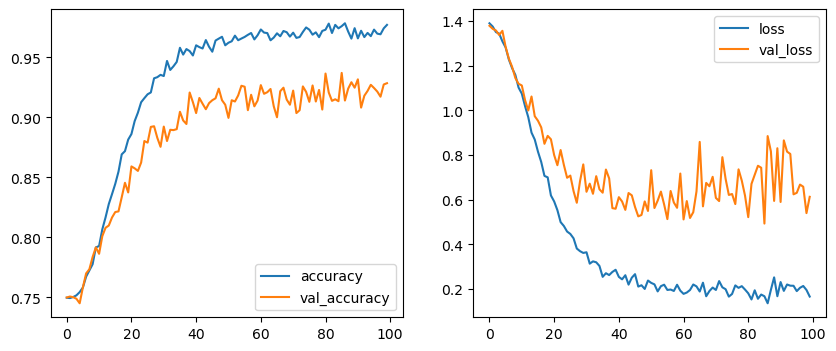

In [9]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].legend(['accuracy', 'val_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss', 'val_loss'])
plt.show()

In [6]:
radar_model.evaluate(x_test, y_test)


35/35 [==============================] - 5s 113ms/step - loss: 0.9104 - accuracy: 0.8874


[0.9104492664337158, 0.8874097466468811]

In [7]:
np.unique(y, return_counts=True)

(array([0., 1.], dtype=float32), array([16608,  5536], dtype=int64))

30/30 [==============================] - 4s 113ms/step


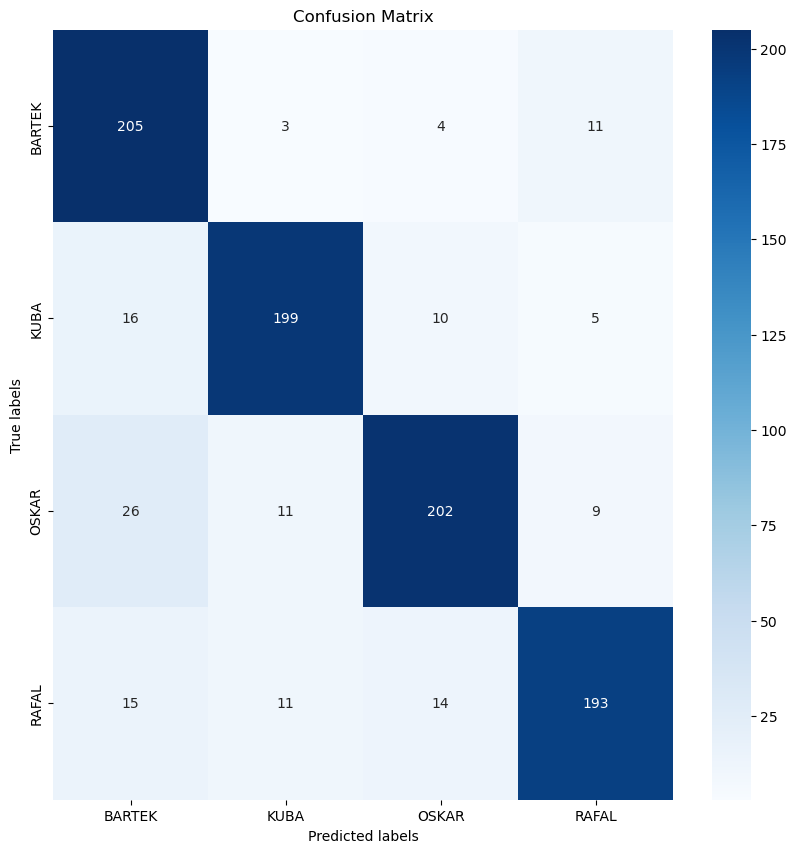

In [10]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = radar_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues',fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()